In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.path.pardir, 'src')))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

from policy import ResNet, ConvNet

# Set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from jem import JointEmbeddingModel, get_data, convert_integers_to_explinations

lr = 0.001
epochs = 10
batch_size = 128
num_epochs = 10
input_state_embed = 64
hidden_state_embed = 32
output_state_embed = 16 
exp_embed = 32
output_exp_embed = 16

model_name = "net"
session_name = "falcon"
board_size = 5
board_name = f'{board_size}x{board_size}'
resnet = False

model_type = "resnet" if resnet else "convnet"

agents_to_sample = [0, 10, 20, 60, 100, 500, 1000]
cases_to_sample = 100

full_model_path = f"../models/saved_sessions/{model_type}/board_size_{board_size}/{session_name}/"

def load_model(full_name, model_name, epoch):
    model_path = full_name + model_name + "_" + str(epoch) + ".keras"
    if resnet:
        model = ResNet(board_size, model_path)
    else:
        model = ConvNet(board_size, model_path)
    return model

agents = [load_model(full_model_path, model_name, epoch) for epoch in agents_to_sample]

# Load the data
states, explinations, labels, max_sent_len, vocab = get_data(agents, cases_to_sample, board_size)

vocab_size = len(vocab)

print(states.shape, explinations.shape, labels.shape, max_sent_len, vocab_size)



Positive cases: 125it [00:31,  3.98it/s]                         
Positive cases: 111it [01:35,  1.16it/s]                         
Positive cases: 133it [00:07, 17.69it/s]                        
Positive cases: 395it [00:08, 47.09it/s]                        

(800, 5, 5, 5) (800, 8) (800,) 8 18


### Train the joint embedding model

In [53]:
jem = JointEmbeddingModel(vocab_size=vocab_size, max_sent_len=max_sent_len, learning_rate=lr)

jem.fit(states, explinations, labels, batch_size=batch_size, epochs=100)

jem.save_model('../models/jem/joint_embedding_model.keras')

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 5, 5, 5)]    0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 5, 5, 4)      184         ['input_19[0][0]']               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 5, 5, 6)      222         ['conv2d_18[0][0]']              
                                                                                                  
 flatten_9 (Flatten)            (None, 150)          0           ['conv2d_19[0][0]']              
                                                                                            

2024-02-16 16:54:25.543359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


7/7 [==============================] - 6s 129ms/step - loss: 41.6698 - combined_output_loss: 41.6698
Epoch 2/100
7/7 [==============================] - 1s 76ms/step - loss: 35.8535 - combined_output_loss: 35.8535
Epoch 3/100
7/7 [==============================] - 1s 73ms/step - loss: 34.6309 - combined_output_loss: 34.6309
Epoch 4/100
7/7 [==============================] - 1s 75ms/step - loss: 33.7321 - combined_output_loss: 33.7321
Epoch 5/100
7/7 [==============================] - 0s 68ms/step - loss: 33.2698 - combined_output_loss: 33.2698
Epoch 6/100
7/7 [==============================] - 1s 73ms/step - loss: 32.7199 - combined_output_loss: 32.7199
Epoch 7/100
7/7 [==============================] - 0s 67ms/step - loss: 32.5107 - combined_output_loss: 32.5107
Epoch 8/100
7/7 [==============================] - 0s 67ms/step - loss: 32.2309 - combined_output_loss: 32.2309
Epoch 9/100
7/7 [==============================] - 0s 66ms/step - loss: 32.0068 - combined_output_loss: 32.0068
Epo

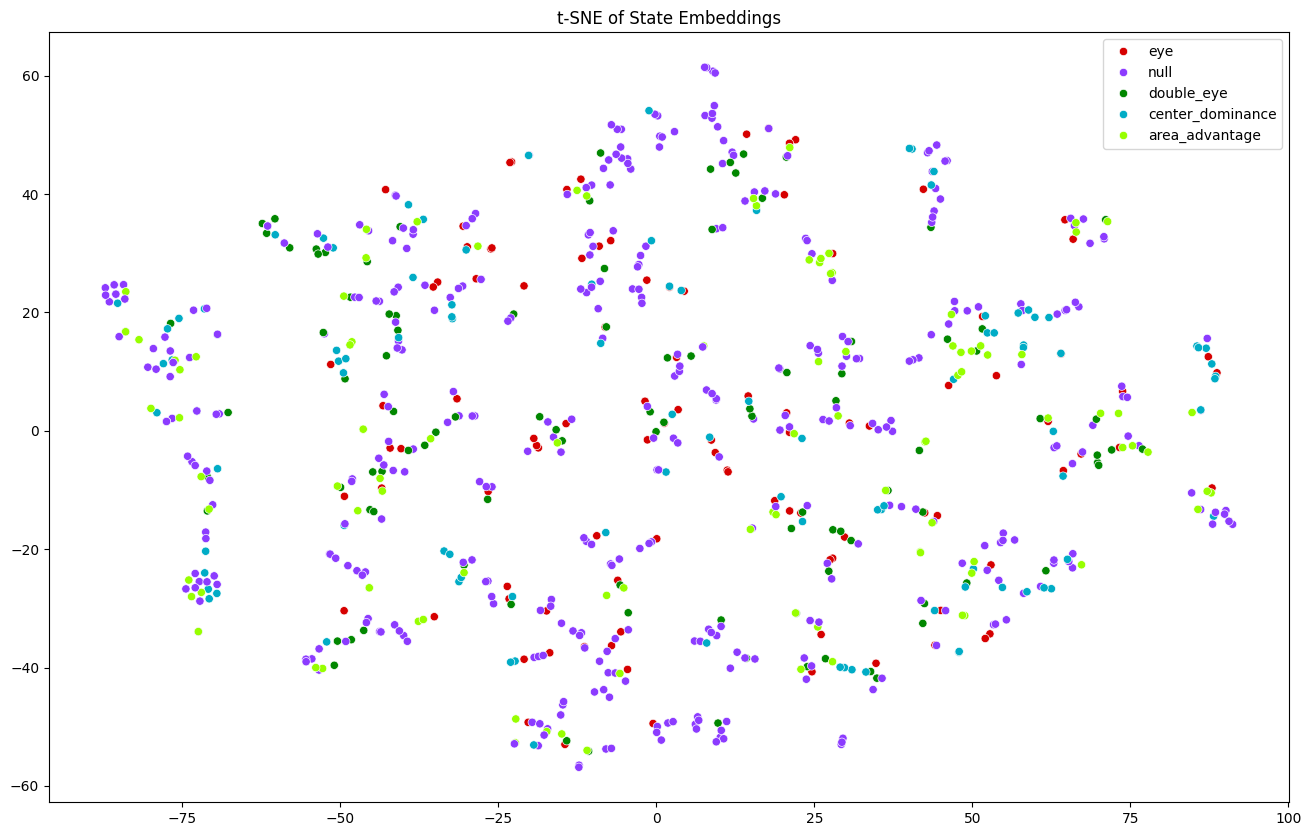

In [54]:
# Import necessary modules
from sklearn.manifold import TSNE
import seaborn as sns
import colorcet as cc

# Define necessary variables
state_embeddings = []
explination_predictions = []

# Get the embeddings
for i in range(len(states)):
    state_embed, exp_embed, _ = jem.predict(states[i], explinations[i])
    state_embeddings.append(state_embed)
    # Get the explination converted to a string
    explination = convert_integers_to_explinations(explinations[i], vocab)
    explination_predictions.append(explination)

new_state_embed = []

for list_ in state_embeddings:
    new_state_embed.append(list_[0])
    
new_state_embed = np.array(new_state_embed)
explination_predictions = np.array(explination_predictions)

# Fit the t-sne
tsne = TSNE(n_components=2, perplexity=5)
state_embed_tsne = tsne.fit_transform(new_state_embed)

# Plot the t-sne
palette = sns.color_palette(cc.glasbey, 5)
plt.figure(figsize=(16,10))
sns.scatterplot(x=state_embed_tsne[:,0], y=state_embed_tsne[:,1], hue=explination_predictions, legend='full', palette=palette)
plt.title('t-SNE of State Embeddings')
plt.plot()
plt.show()